### ปฏิบัติการครั้งที่ 9

ดาวน์โหลดข้อมูลอุณหภูมิสูงสุดรายวันปี 1998-2019 จาก link ข้างล่างนี้  
https://donlapark.pages.dev/229351/data/CM_temp.csv

1. เปลี่ยนจากข้อมูลรายวันให้เป็นข้อมูลค่าเฉลี่ยรายเดือน
2. จงแบ่งข้อมูลโดยให้ Test set เป็นข้อมูลของ 2 ปีสุดท้ายและ Training set เป็นข้อมูลที่เหลือ
3. ทดสอบหาค่า d ที่เหมาะสมโดยใช้ KPSS และ ADF
4. ลองสร้างโมเดล SARIMA อันดับต่างๆ แล้วระบุโมเดลที่ดีที่สุด
5. จงแสดงแผนภาพของข้อมูลจริงกับข้อมูลที่ได้ในข้อ 3

In [ ]:
# ONLY RUN THIS WHEN THERE IS AN ERROR
!pip install --user statsmodels==0.13.1

In [ ]:
!wget -O CM_temp.csv https://donlapark.pages.dev/229351/data/CM_temp.csv

--2024-02-15 04:42:51--  https://donlapark.pages.dev/229351/data/CM_temp.csv
Resolving donlapark.pages.dev (donlapark.pages.dev)... 172.66.47.56, 172.66.44.200, 2606:4700:310c::ac42:2f38, ...
Connecting to donlapark.pages.dev (donlapark.pages.dev)|172.66.47.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139473 (136K) [text/csv]
Saving to: ‘CM_temp.csv’

CM_temp.csv         100%[===================>] 136.20K  --.-KB/s    in 0.01s   

2024-02-15 04:42:51 (10.7 MB/s) - ‘CM_temp.csv’ saved [139473/139473]



In [ ]:
!pip3 install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.2 MB/s eta 0:00:00


In [ ]:
# import module ที่ต้องใช้
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA


### 1. เปลี่ยนจากข้อมูลรายวันให้เป็นข้อมูลค่าเฉลี่ยรายเดือน

In [ ]:
# ฟังก์ชันที่เปลี่ยน string ให้เป็น datetime
def parser(dates):
  return pd.datetime.strptime(dates, '%Y-%m-%d')

# parse_dates ชื่อของคอลัมน์ที่จะเปลี่ยนให้เป็น datetime
# index_col ชื่อของคอลัมน์ที่จะให้เป็น index
# date_parser ฟังก์ชันที่เปลี่ยน string ให้เป็น datetime
data = pd.read_csv('CM_temp.csv', parse_dates=['Date'],
                                        index_col='Date',
                                        date_parser=parser)

data.head()

<ipython-input-4-7313849a4eeb>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime.strptime(dates, '%Y-%m-%d')


,MaxTemp
Date,
1998-01-01,30.6
1998-01-02,32.0
1998-01-03,31.6
1998-01-04,32.1
1998-01-05,31.2


ข้อมูล (สมมติว่าชื่อ `data`) ที่ load มาเป็นข้อมูลรายวัน ทำการหาค่าเฉลี่ยรายเดือนด้วยคำสั่ง

In [ ]:
y = data['MaxTemp'].resample("M").mean()

In [ ]:
def rmse(y_true,y_pred):
  # Inputs
  # y_true: actual value, y_pred: predicted values
  # Output: RMSE between y_true and y_pred
  return np.sqrt(np.mean(np.square(y_true-y_pred)))

### 2. จงแบ่งข้อมูลโดยให้ Test set เป็นข้อมูลของ 2 ปีสุดท้ายและ Training set เป็นข้อมูลที่เหลือ

In [ ]:
train = y[:-24]
test = y[-24:]

print(test)

Date
2017-08-31    32.764516
2017-09-30    33.140000
2017-10-31    32.158065
2017-11-30    31.616667
2017-12-31    29.229032
2018-01-31    30.048387
2018-02-28    33.253571
2018-03-31    35.674194
2018-04-30    35.900000
2018-05-31    34.648387
2018-06-30    33.066667
2018-07-31    32.000000
2018-08-31    32.258065
2018-09-30    33.506667
2018-10-31    32.864516
2018-11-30    32.336667
2018-12-31    30.229032
2019-01-31    30.622581
2019-02-28    34.564286
2019-03-31    37.051613
2019-04-30    39.716667
2019-05-31    37.680645
2019-06-30    35.466667
2019-07-31    34.070968
Freq: M, Name: MaxTemp, dtype: float64


### 3. ทดสอบหาค่า d ที่เหมาะสมโดยใช้ KPSS และ ADF

#### Test stationarity

#### KPSS
- $H_0$: data is stationary # เราอยากได้สมมติฐานหลักนี้
- $H_1$: data is **not** stationary # สมมติฐานแย้งนี้เราไม่อยากได้


#### ADF (Dickey-Fuller)
- $H_0$: data is **not** stationary
- $H_1$: data is stationary


In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

def KPSStest(timeseries):
  kpsstest = kpss(timeseries)
  print('KPSS test')
  print('Test Statistic: ',kpsstest[0])
  print('p-value: ',kpsstest[1])
  print('Number of Observations Used: ',kpsstest[2])
  print('Critical Values: ',kpsstest[3])

def ADFtest(timeseries):
  adftest = adfuller(timeseries)
  print('ADF test')
  print('Test Statistic: ',adftest[0])
  print('p-value: ',adftest[1])
  print('#Lags Used: ',adftest[2])
  print('Number of Observations Used: ',adftest[3])
  print('Critical Values: ',adftest[4])

In [ ]:
KPSStest(y) # if p-value < 0.05 -> Accept H1 (Reject H0) -> not stationary
ADFtest(y) # p-value > 0.05 -> Accept H0 -> not stationary

KPSS test
Test Statistic:  0.6428439386603282
p-value:  0.018741460121788345
Number of Observations Used:  4
Critical Values:  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
ADF test
Test Statistic:  -2.222023197657817
p-value:  0.19834961731512274
#Lags Used:  13
Number of Observations Used:  245
Critical Values:  {'1%': -3.4573260719088132, '5%': -2.873410402808354, '10%': -2.573095980841316}


In [ ]:
# ทำการ Differencing 1 รอบ
y_diff = y-y.shift()
y_diff.dropna(inplace=True)

KPSStest(y_diff) # p-value > 0.05 -> Accept H0 -> stationary
ADFtest(y_diff) # p-value < 0.05 -> Accept H1 -> stationary

KPSS test
Test Statistic:  0.04516874529942415
p-value:  0.1
Number of Observations Used:  28
Critical Values:  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
ADF test
Test Statistic:  -6.227064576112576
p-value:  5.0583827570587737e-08
#Lags Used:  12
Number of Observations Used:  245
Critical Values:  {'1%': -3.4573260719088132, '5%': -2.873410402808354, '10%': -2.573095980841316}


<ipython-input-9-69c709c00ffc>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries)


#### Answer: ค่า d ที่เหมาะสมคือ 1 เนื่องจากหลังจากทำการ Differencing 1 รอบแล้วพบว่า ข้อมูลเป็น stationary

### 4. ลองสร้างโมเดล SARIMA อันดับต่างๆ แล้วระบุโมเดลที่ดีที่สุด


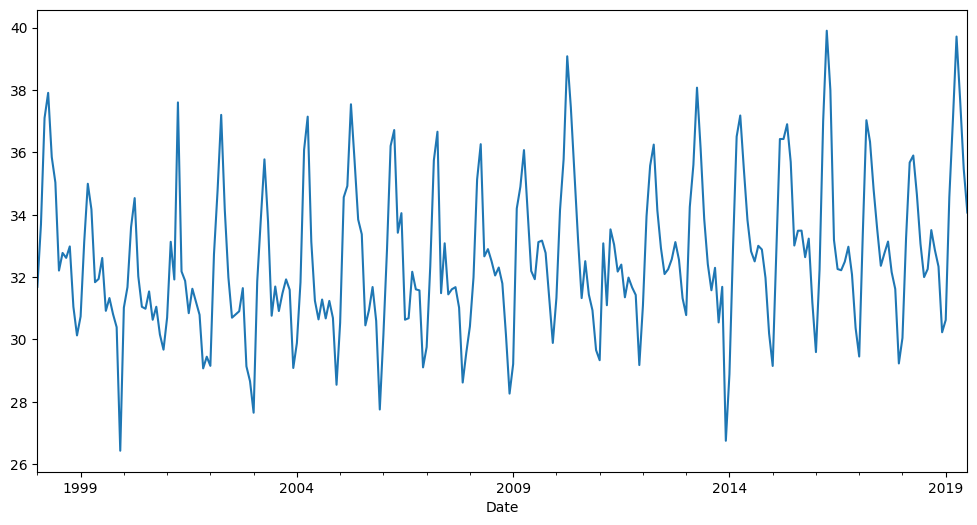

In [ ]:
plt.figure(figsize=(12,6))
ax = y.plot()

#### จากการทดลอง plot ข้อมูลพบว่าข้อมูลนี้มี Seasonality ดังนั้น เราจะใช้โมเดล SARIMA

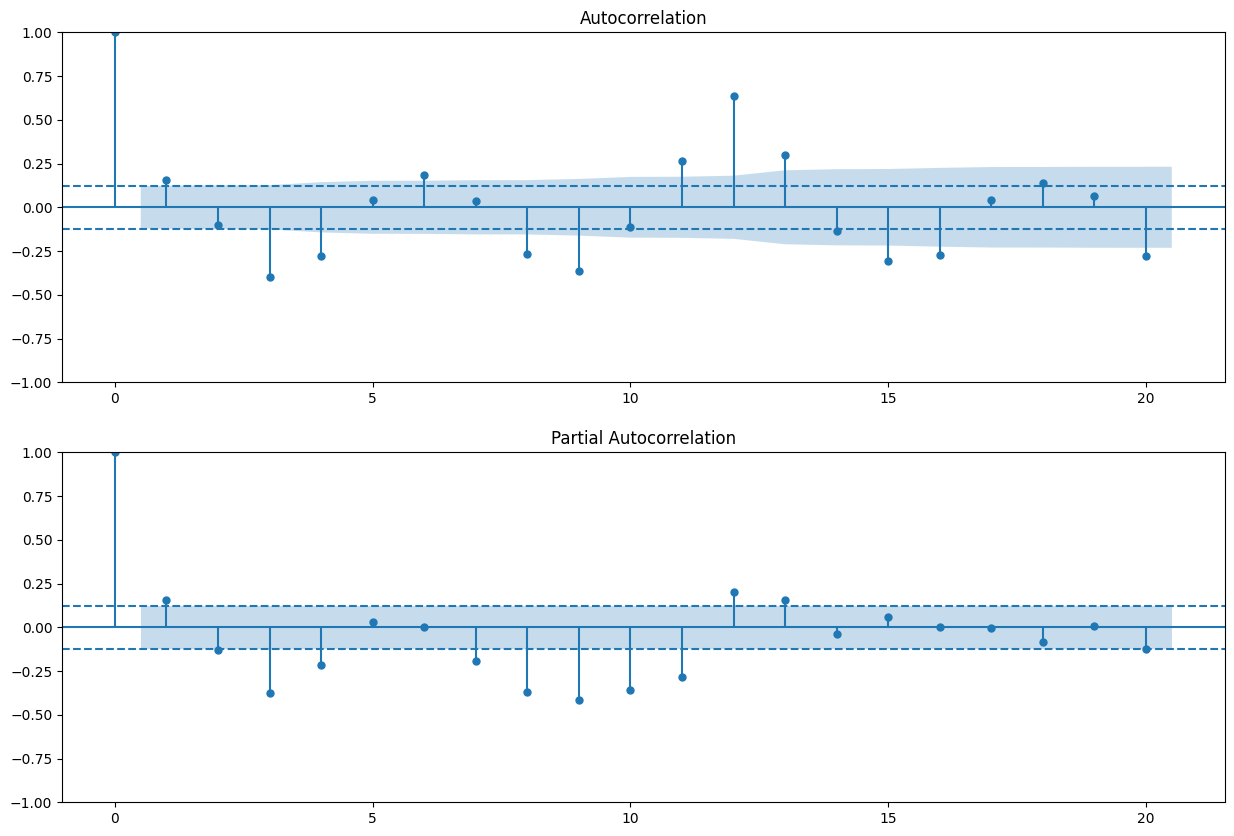

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2,1,figsize=(15, 10))

plot_acf(y_diff, lags=20, ax=ax[0]);
ax[0].axhline(y=-1.96/(len(y)-1)**.5, linestyle = '--')
ax[0].axhline(y=1.96/(len(y)-1)**.5, linestyle = '--')

plot_pacf(y_diff, lags=20, ax=ax[1]);
ax[1].axhline(y=-1.96/(len(y)-1)**.5, linestyle = '--')
ax[1].axhline(y=1.96/(len(y)-1)**.5, linestyle = '--')

ลองเลือก order = (0, 1, 0)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: optimized. After release 0.14, this will raise.
  warnings.warn(


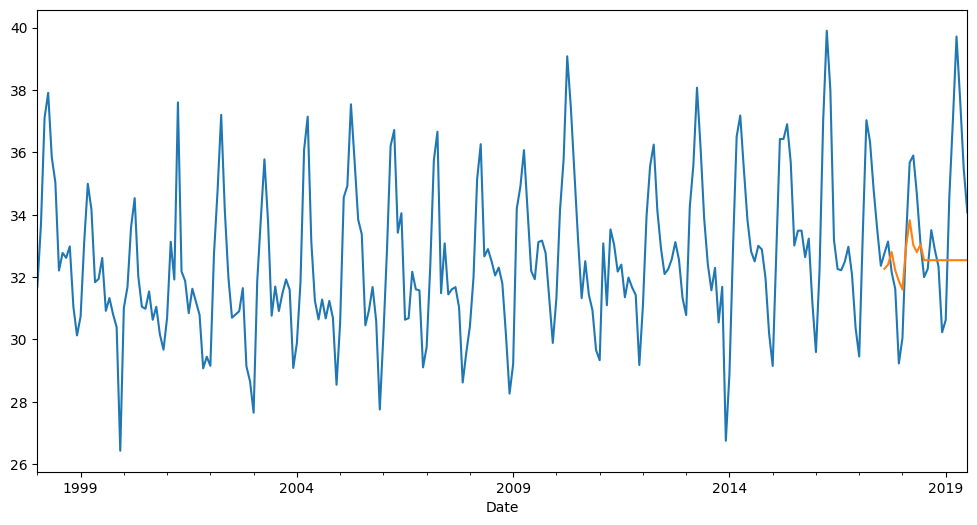

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima = SARIMAX(train, order=(0, 1, 0), seasonal_order=(0, 0, 1, 12)) # 24 คือ Season หนึ่งมีทั้งหมดกี่หน่วยเวลา ในที่นี่คือ 2 ปีมี 24 เดือน

sarima_fit = sarima.fit(optimized=True)
yhat = sarima_fit.predict('2017-08-31', '2019-07-31')

plt.figure(figsize=(12,6))
y.plot()
yhat.plot();

In [ ]:
print('RMSE:',rmse(test,yhat))

RMSE: 2.498552511210365


#### พบว่า model ยังทำนายไม่แม่นยำพอ ใช้ auto_arima จาก pmdarima เพื่อหา order ที่เหมาะสมที่สุด

In [ ]:
!pip3 install pmdarima

In [ ]:
import pmdarima as pm

auto_fit = pm.auto_arima(train, start_p=0, start_q=0, max_p=3, max_q=3, d=1,
                             seasonal=True, m=12, start_P=0, start_Q=0, D=1,
                             information_criterion = 'aicc', # choose model with the lowest corrected AIC
                             trace = True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True) # don't want convergence warnings

Performing stepwise search to minimize aicc
 ARIMA(0,1,0)(0,1,0)[12]             : AICC=861.244, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AICC=768.874, Time=0.45 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AICC=700.046, Time=0.87 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AICC=799.244, Time=0.17 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AICC=inf, Time=1.82 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AICC=inf, Time=3.35 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AICC=748.519, Time=0.49 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AICC=inf, Time=13.96 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AICC=765.293, Time=0.70 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AICC=697.708, Time=2.72 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AICC=inf, Time=1.67 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AICC=inf, Time=2.22 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AICC=inf, Time=4.07 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AICC=744.812, Time=1.56 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AI

In [ ]:
auto_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  235
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -342.969
Date:                              Thu, 15 Feb 2024   AIC                            695.938
Time:                                      05:29:31   BIC                            712.951
Sample:                                  01-31-1998   HQIC                           702.807
                                       - 07-31-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7742      0.106      7.334      0.000       0.567       0.981
ma.L1         -1.4279      0.137    -10.413      0.000      -1.697      -1.159
ma.L2          0.4396      0.127      3.462      0.001       0.191       0.688
ma.S.L12      -0.8488      0.064    -13.194      0.000      -0.975      -0.723
sigma2         1.1804      0.107     11.036      0.000       0.971       1.390
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                14.27
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.26
Prob(H) (two-sided):                  0.50   Kurtosis:                         4.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### โมเดลที่ดีที่สุด คือ ARIMA(1,1,2)(0,1,1)[12]

### 4. จงแสดงแผนภาพของข้อมูลจริงกับข้อมูลที่ได้ในข้อ 3

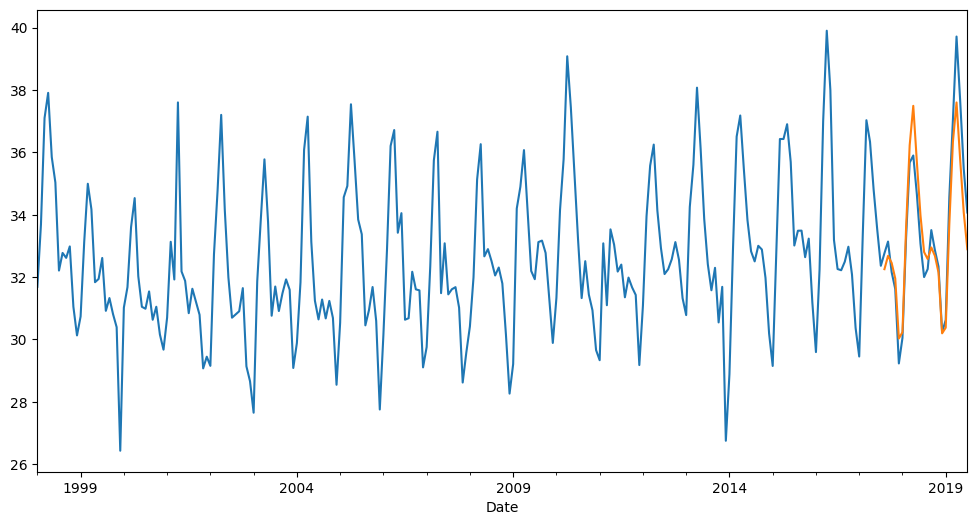

In [ ]:
predictions = auto_fit.predict(24)
yhat = pd.Series(predictions,
                    index=test.index) # ที่สำคัญคือตรงนี้ index ตรงนี้ต้องเท่ากับ index ใน test set

plt.figure(figsize=(12,6))
ax = y.plot()
yhat.plot(ax=ax);

In [ ]:
print('RMSE:',rmse(test,yhat))

RMSE: 0.9135622788846456
